# Plot intervalli di confidenza

Notebook per "plottare" gli intervalli di confidenza dei test effettuati.
Vengono letti tutti i risultati delle evaluations presenti su disco e raggruppati in base ai parametri di input.
> NB:
> - i test sono stati effettuati con valori random per il seed per generare una base di campioni da confrontare.
> - per problemi legati al tempo di esecuzione dei test il numero di campioni delle popolazioni sono ridotti per cui è stato calcolato lo standard error sui singoli campioni a disposizione per ogni impostazione ed utilizzata la statistica "t" al posto della distribuzione normale ("z-score")

## Caricamento dei dati disco

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
curdir = Path('.')
stat = pd.DataFrame()
for f in curdir.glob('eval*'):
    df = pd.read_pickle(f)
    stat = pd.concat([stat, df])
print(stat)

   action_accuracy  action_perplexity  attribute_accuracy  \
0         0.845655           4.842728            0.771190   
0         0.851399           3.448803            0.776654   
0         0.841949           4.911037            0.757051   
0         0.844543           4.939461            0.763818   
0         0.840467           4.647734            0.760981   
0         0.844543           4.883573            0.777004   
0         0.847137           4.110154            0.768996   
0         0.844729           5.151854            0.772405   

                                    confusion_matrix  params.batch  \
0  [[742.0, 45.0, 13.0, 13.0, 15.0], [29.0, 1086....            12   
0  [[746.0, 49.0, 10.0, 4.0, 11.0], [27.0, 1084.0...            12   
0  [[750.0, 45.0, 16.0, 11.0, 12.0], [21.0, 1089....            12   
0  [[749.0, 46.0, 12.0, 10.0, 13.0], [26.0, 1081....            12   
0  [[751.0, 53.0, 9.0, 7.0, 18.0], [23.0, 1084.0,...            12   
0  [[735.0, 45.0, 14.0, 7.0, 1

## Calcolo statistiche

In [2]:
stat_mean = stat.drop('params.seed', 1).groupby(['params.epochs', 'params.batch', 'params.hidden_output_dim', 'params.learning_rate', 'params.tolerance']).mean().add_suffix('_mean')
stat_std = stat.drop('params.seed', 1).groupby(['params.epochs', 'params.batch', 'params.hidden_output_dim', 'params.learning_rate', 'params.tolerance']).std().add_suffix('_std')
stat_var = stat.drop('params.seed', 1).groupby(['params.epochs', 'params.batch', 'params.hidden_output_dim', 'params.learning_rate', 'params.tolerance']).var().add_suffix('_var')
stat_stderr = stat.drop('params.seed', 1).groupby(['params.epochs', 'params.batch', 'params.hidden_output_dim', 'params.learning_rate', 'params.tolerance']).sem().add_suffix('_std_err')

stat_group = stat.drop('params.seed', 1).groupby(['params.epochs', 'params.batch', 'params.hidden_output_dim', 'params.learning_rate', 'params.tolerance'])
#stat_df = stat_group.merge(stat_group.mean().add_suffix('_mean'))
#stat_df = stat_group.mean().add_suffix('_mean')
#stat_df1 = stat_group.std().add_suffix('_std')
df = stat_group.describe()
for prop in df:
    print(prop)
print(df.index)
df

('action_accuracy', 'count')
('action_accuracy', 'mean')
('action_accuracy', 'std')
('action_accuracy', 'min')
('action_accuracy', '25%')
('action_accuracy', '50%')
('action_accuracy', '75%')
('action_accuracy', 'max')
('action_perplexity', 'count')
('action_perplexity', 'mean')
('action_perplexity', 'std')
('action_perplexity', 'min')
('action_perplexity', '25%')
('action_perplexity', '50%')
('action_perplexity', '75%')
('action_perplexity', 'max')
('attribute_accuracy', 'count')
('attribute_accuracy', 'mean')
('attribute_accuracy', 'std')
('attribute_accuracy', 'min')
('attribute_accuracy', '25%')
('attribute_accuracy', '50%')
('attribute_accuracy', '75%')
('attribute_accuracy', 'max')
MultiIndex([(10, 12, 256, 5e-05, 1e-08)],
           names=['params.epochs', 'params.batch', 'params.hidden_output_dim', 'params.learning_rate', 'params.tolerance'])


action_accuracy  \
                                                                                                    count   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance                   
10            12           256                      0.00005              1.000000e-08                 8.0   

                                                                                                     \
                                                                                               mean   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.845053   

                                                                                                     \
                                                                                                std   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.003301   

                                                                                                     \
                                                                                                min   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.840467   

                                                                                                     \
                                                                                                25%   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.843895   

                                                                                                     \
                                                                                                50%   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.844636   

                                                                                                     \
                                                                                                75%   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.846026   

                                                                                                     \
                                                                                                max   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.851399   

                                                                                          action_perplexity  \
                                                                                                      count   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance                     
10            12           256                      0.00005              1.000000e-08                   8.0   

                                                                                                     \
                                                                                               mean   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10      

# Standard error (per calcolo intervallo di confidenza)

In [3]:
t_dist_2_tailed_95 = [np.nan, 
                      12.71, 4.3, 3.18, 2.78, 2.57, 2.45, 2.36, 2.31, 2.26, 2.23, 
                      2.20, 2.18, 2.16, 2.14, 2.13, 2.12, 2.11, 2.10, 2.09, 2.09, 
                      2.08, 2.07, 2.07, 2.06, 2.06, 2.06, 2.05, 2.05, 2.05, 2.04]
df['degree_of_freedom'] = df[('action_accuracy', 'count')] - 1
df['t_N_minus_1'] = df['degree_of_freedom'].apply(lambda x: t_dist_2_tailed_95[int(x)])

df[('action_accuracy', 'stderr')] = df[('action_accuracy', 'std')] / np.sqrt(df[('action_accuracy', 'count')])
df[('action_accuracy', 'ci')] = df['t_N_minus_1'] * df[('action_accuracy', 'stderr')]
df[('action_accuracy', 'lo_bond_ci')] = df[('action_accuracy', 'mean')] - df['t_N_minus_1'] * df[('action_accuracy', 'stderr')]
df[('action_accuracy', 'up_bond_ci')] = df[('action_accuracy', 'mean')] + df['t_N_minus_1'] * df[('action_accuracy', 'stderr')]

df[('action_perplexity', 'stderr')] = df[('action_perplexity', 'std')] / np.sqrt(df[('action_perplexity', 'count')])
df[('action_perplexity', 'ci')] = df['t_N_minus_1'] * df[('action_perplexity', 'stderr')]
df[('action_perplexity', 'lo_bond_ci')] = df[('action_perplexity', 'mean')] - df['t_N_minus_1'] * df[('action_perplexity', 'stderr')]
df[('action_perplexity', 'up_bond_ci')] = df[('action_perplexity', 'mean')] + df['t_N_minus_1'] * df[('action_perplexity', 'stderr')]

df[('attribute_accuracy', 'stderr')] = df[('attribute_accuracy', 'std')] / np.sqrt(df[('attribute_accuracy', 'count')])
df[('attribute_accuracy', 'ci')] = df['t_N_minus_1'] * df[('attribute_accuracy', 'stderr')]
df[('attribute_accuracy', 'lo_bond_ci')] = df[('attribute_accuracy', 'mean')] - df['t_N_minus_1'] * df[('attribute_accuracy', 'stderr')]
df[('attribute_accuracy', 'up_bond_ci')] = df[('attribute_accuracy', 'mean')] + df['t_N_minus_1'] * df[('attribute_accuracy', 'stderr')]

df

action_accuracy  \
                                                                                                    count   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance                   
10            12           256                      0.00005              1.000000e-08                 8.0   

                                                                                                     \
                                                                                               mean   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.845053   

                                                                                                     \
                                                                                                std   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.003301   

                                                                                                     \
                                                                                                min   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.840467   

                                                                                                     \
                                                                                                25%   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.843895   

                                                                                                     \
                                                                                                50%   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.844636   

                                                                                                     \
                                                                                                75%   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.846026   

                                                                                                     \
                                                                                                max   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10            12           256                      0.00005              1.000000e-08      0.851399   

                                                                                          action_perplexity  \
                                                                                                      count   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance                     
10            12           256                      0.00005              1.000000e-08                   8.0   

                                                                                                     \
                                                                                               mean   
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance             
10      

In [4]:
df = df.reset_index()
df.index
df['class'] = f"E{df['params.epochs']}-B{df['params.batch']}-H{df['params.hidden_output_dim']}"
for prop in df:
    print(prop)
x = df[('action_accuracy', 'mean')]
y = df['class']
xerr = df[('action_accuracy', 'ci')]

('params.epochs', '')
('params.batch', '')
('params.hidden_output_dim', '')
('params.learning_rate', '')
('params.tolerance', '')
('action_accuracy', 'count')
('action_accuracy', 'mean')
('action_accuracy', 'std')
('action_accuracy', 'min')
('action_accuracy', '25%')
('action_accuracy', '50%')
('action_accuracy', '75%')
('action_accuracy', 'max')
('action_perplexity', 'count')
('action_perplexity', 'mean')
('action_perplexity', 'std')
('action_perplexity', 'min')
('action_perplexity', '25%')
('action_perplexity', '50%')
('action_perplexity', '75%')
('action_perplexity', 'max')
('attribute_accuracy', 'count')
('attribute_accuracy', 'mean')
('attribute_accuracy', 'std')
('attribute_accuracy', 'min')
('attribute_accuracy', '25%')
('attribute_accuracy', '50%')
('attribute_accuracy', '75%')
('attribute_accuracy', 'max')
('degree_of_freedom', '')
('t_N_minus_1', '')
('action_accuracy', 'stderr')
('action_accuracy', 'ci')
('action_accuracy', 'lo_bond_ci')
('action_accuracy', 'up_bond_ci')
('a

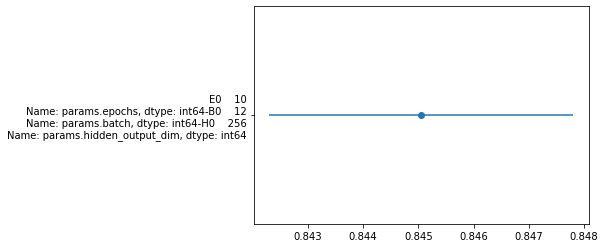

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.errorbar(x = x, y = y, xerr = xerr, fmt = '-o')
plt.show()

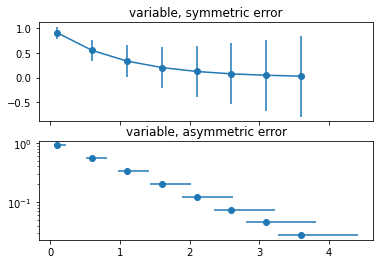

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)

# example error bar values that vary with x-position
error = 0.1 + 0.2 * x

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.errorbar(x, y, yerr=error, fmt='-o')
ax0.set_title('variable, symmetric error')

# error bar values w/ different -/+ errors that
# also vary with the x-position
lower_error = 0.4 * error
upper_error = error
asymmetric_error = [lower_error, upper_error]

ax1.errorbar(x, y, xerr=asymmetric_error, fmt='o')
ax1.set_title('variable, asymmetric error')
ax1.set_yscale('log')
plt.show()